In [1]:
import os
import sys
import math
import json
import time
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Import the Modules dir
project_path = "<PATH-TO-REPO>/BiMAEB-UDD-RUL/"
sys.path.insert(0, project_path)

from Modules.Models import AutoEncoder
from experimental_results.functions import (TURBOFAN_FEATURES_LIST, 
                       save_labeled_dataframe,
                       normalize_df, 
                       normalize_df_with_context,
                       get_model_reconstructions, 
                       get_latent_space_df)

from experimental_results.unsupervised_labeling_functions import (label_df, 
                                                                  plot_latent_space,
                                                                  plot_labels_recon_errors_and_threshold, 
                                                                  create_unsupervised_labeled_dataset)

In [8]:
TURBOFAN_FEATURES_LIST

['operational_setting_1',
 'operational_setting_2',
 'operational_setting_3',
 'sensor_measurement_1',
 'sensor_measurement_2',
 'sensor_measurement_3',
 'sensor_measurement_4',
 'sensor_measurement_5',
 'sensor_measurement_6',
 'sensor_measurement_7',
 'sensor_measurement_8',
 'sensor_measurement_9',
 'sensor_measurement_10',
 'sensor_measurement_11',
 'sensor_measurement_12',
 'sensor_measurement_13',
 'sensor_measurement_14',
 'sensor_measurement_15',
 'sensor_measurement_16',
 'sensor_measurement_17',
 'sensor_measurement_18',
 'sensor_measurement_19',
 'sensor_measurement_20',
 'sensor_measurement_21']

# Define the number of samples that were defined as normal in the time-series

In [2]:
normal_op_len = 45
norm_op_len_as_pct = True

dataset = "FD003"
model_type = "AE"
prefix = "Pct" if norm_op_len_as_pct else "Len"


print(f"Normality: {normal_op_len} {prefix}")

Normality: 45 Pct


# Define Paths and File Names

In [3]:
model_name = f"normOp{prefix}{normal_op_len}_{model_type}"

# Define path's to data directories.
path_to_training_data_dir = "<PATH-TO-DATA-DIR>/NASA_turbofan_data/train"
path_to_testing_data_dir = "<PATH-TO-DATA-DIR>/NASA_turbofan_data/validation"

# Define CSV file names
csv_file_training = f"{dataset}_train.csv"
csv_file_testing = f"{dataset}_test.csv"

# Define paths
dataset_path_training = os.path.join(path_to_training_data_dir, csv_file_training)
dataset_path_testing = os.path.join(path_to_testing_data_dir, csv_file_testing)

path_to_model_state_dict = f"models/{model_name}_model_state_dict"

print(f"Model Path: {path_to_model_state_dict}")

Model Path: models/normOpPct45_AE_model_state_dict


# Load the Training and Testing Data. Normalize them too

In [4]:
print(f"Reading dataset \n{dataset_path_training}\n")
print(f"Reading dataset \n{dataset_path_testing}")

# Read data
df_training_not_normalized = pd.read_csv(dataset_path_training)
df_testing_not_normalized = pd.read_csv(dataset_path_testing)

print("\nNormalizing datasets...\n")
# Normalize Datasets
df_training_normalized = normalize_df(df=df_training_not_normalized, 
                                      model_features=TURBOFAN_FEATURES_LIST)

df_testing_normalized = normalize_df_with_context(df=df_testing_not_normalized, 
                                                  df_context=df_training_not_normalized, 
                                                  model_features=TURBOFAN_FEATURES_LIST)
print("Done!")

Reading dataset 
/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/train/FD003_train.csv

Reading dataset 
/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/validation/FD003_test.csv

Normalizing datasets...

Done!


In [5]:
# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using Device: {}".format(device))

Using Device: cpu


# Set Model and Data Parameters. 
`window_size` is a variable that tells us how many samples in each sample. 
`latent_size` is a variable that defines the latent space size.

In [6]:
window_size = 1
latent_size = 16
ts_number_features = len(TURBOFAN_FEATURES_LIST)

print(f"Latent Size: {latent_size}")
print(f"Number ts features: {ts_number_features}")

Latent Size: 16
Number ts features: 24


# Load the Trained Model

In [9]:
model = AutoEncoder(ts_number_features=ts_number_features,
                    latent_size=latent_size,
                    device=device,
                    model_name="",
                    metrics_dir="model")

print(f"Reading model at '{path_to_model_state_dict}'")
model.load_state_dict(torch.load(path_to_model_state_dict, map_location=torch.device(device)))

Reading model at 'models/normOpPct45_AE_model_state_dict'


<All keys matched successfully>

# Label Both Training and Testing Data With the Model

In [10]:
# Label Training Data!
num_contiguous_anomalous_samples = 3
num_stds = 3
df_unsuperivsed_labels_training, unit_thresholds_dict = create_unsupervised_labeled_dataset(
                                                            model=model, 
                                                            df=df_training_normalized, 
                                                            identifier_col="unit", 
                                                            cycle_col="cycle", 
                                                            fault_col="fault",
                                                            features_list=TURBOFAN_FEATURES_LIST,
                                                            normal_op_len=normal_op_len, 
                                                            normal_op_len_as_pct=norm_op_len_as_pct,
                                                            num_contiguous_anomalous_samples=num_contiguous_anomalous_samples,
                                                            num_stds=num_stds)

Unit 1
	Training Samples:    117
	Normal Samples:      116
	Abnormal Samples:    26

Unit 2
	Training Samples:    114
	Normal Samples:      97
	Abnormal Samples:    42

Unit 3
	Training Samples:    100
	Normal Samples:      82
	Abnormal Samples:    40

Unit 4
	Training Samples:    123
	Normal Samples:      55
	Abnormal Samples:    94

Unit 5
	Training Samples:    96
	Normal Samples:      58
	Abnormal Samples:    59

Unit 6
	Training Samples:    126
	Normal Samples:      86
	Abnormal Samples:    66

Unit 7
	Training Samples:    191
	Normal Samples:      119
	Abnormal Samples:    114

Unit 8
	Training Samples:    121
	Normal Samples:      92
	Abnormal Samples:    54

Unit 9
	Training Samples:    183
	Normal Samples:      117
	Abnormal Samples:    106

Unit 10
	Training Samples:    217
	Normal Samples:      110
	Abnormal Samples:    154

Unit 11
	Training Samples:    89
	Normal Samples:      38
	Abnormal Samples:    70

Unit 12
	Training Samples:    77
	Normal Samples:      70
	Abnormal S

In [11]:
len(df_unsuperivsed_labels_training.query("fault==1")["unit"].unique())

100

In [12]:
df_unsupervised_labels_testing = create_unsupervised_labeled_dataset(
                                    model=model, 
                                    df=df_testing_normalized, 
                                    identifier_col="unit", 
                                    cycle_col="cycle", 
                                    fault_col="fault",
                                    features_list=TURBOFAN_FEATURES_LIST,
                                    normal_op_len=0, 
                                    normal_op_len_as_pct=norm_op_len_as_pct,
                                    num_contiguous_anomalous_samples=num_contiguous_anomalous_samples,
                                    num_stds=num_stds, 
                                    unit_thresholds_dict=unit_thresholds_dict)

Unit 1
	Training Samples:    0
	Normal Samples:      233
	Abnormal Samples:    0

Unit 2
	Training Samples:    0
	Normal Samples:      124
	Abnormal Samples:    0

Unit 3
	Training Samples:    0
	Normal Samples:      208
	Abnormal Samples:    26

Unit 4
	Training Samples:    0
	Normal Samples:      68
	Abnormal Samples:    0

Unit 5
	Training Samples:    0
	Normal Samples:      89
	Abnormal Samples:    49

Unit 6
	Training Samples:    0
	Normal Samples:      64
	Abnormal Samples:    0

Unit 7
	Training Samples:    0
	Normal Samples:      158
	Abnormal Samples:    0

Unit 8
	Training Samples:    0
	Normal Samples:      192
	Abnormal Samples:    0

Unit 9
	Training Samples:    0
	Normal Samples:      238
	Abnormal Samples:    0

Unit 10
	Training Samples:    0
	Normal Samples:      131
	Abnormal Samples:    0

Unit 11
	Training Samples:    0
	Normal Samples:      103
	Abnormal Samples:    0

Unit 12
	Training Samples:    0
	Normal Samples:      146
	Abnormal Samples:    0

Unit 13
	Train

# Save Data to Their Respective Directories

In [13]:
# Create the path where to save the DataFrame
file_name_for_labeled_training_data = csv_file_training[:-4] + f"_unsupervised_labels_{model.model_type}_Op{prefix}{normal_op_len}.csv"
save_labeled_dataframe(file_name=file_name_for_labeled_training_data, 
                       save_path=path_to_training_data_dir,
                       df_labeled=df_unsuperivsed_labels_training, 
                       df_unlabeled=df_training_not_normalized)

Saved 'FD003_train_unsupervised_labels_AutoEncoder_OpPct45.csv' to -->
'/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/train'


In [14]:
file_name_for_labeled_testing_data = csv_file_testing[:-4] + f"_unsupervised_labels_{model.model_type}_Op{prefix}{normal_op_len}.csv"
save_labeled_dataframe(file_name=file_name_for_labeled_testing_data, 
                       save_path=path_to_testing_data_dir,
                       df_labeled=df_unsupervised_labels_testing, 
                       df_unlabeled=df_testing_not_normalized)

Saved 'FD003_test_unsupervised_labels_AutoEncoder_OpPct45.csv' to -->
'/Users/rafaeltoche/Documents/School/Research/Rainwaters_Lab/DART-LP2/Condition_Monitoring/data/NASA_turbofan_data/validation'


In [18]:
df_latent_space = get_latent_space_df(model=model, 
                                      df=df_unsuperivsed_labels_training, 
                                      unit_col_identifier_name="unit",
                                      cycle_col="cycle",
                                      features_list=TURBOFAN_FEATURES_LIST)

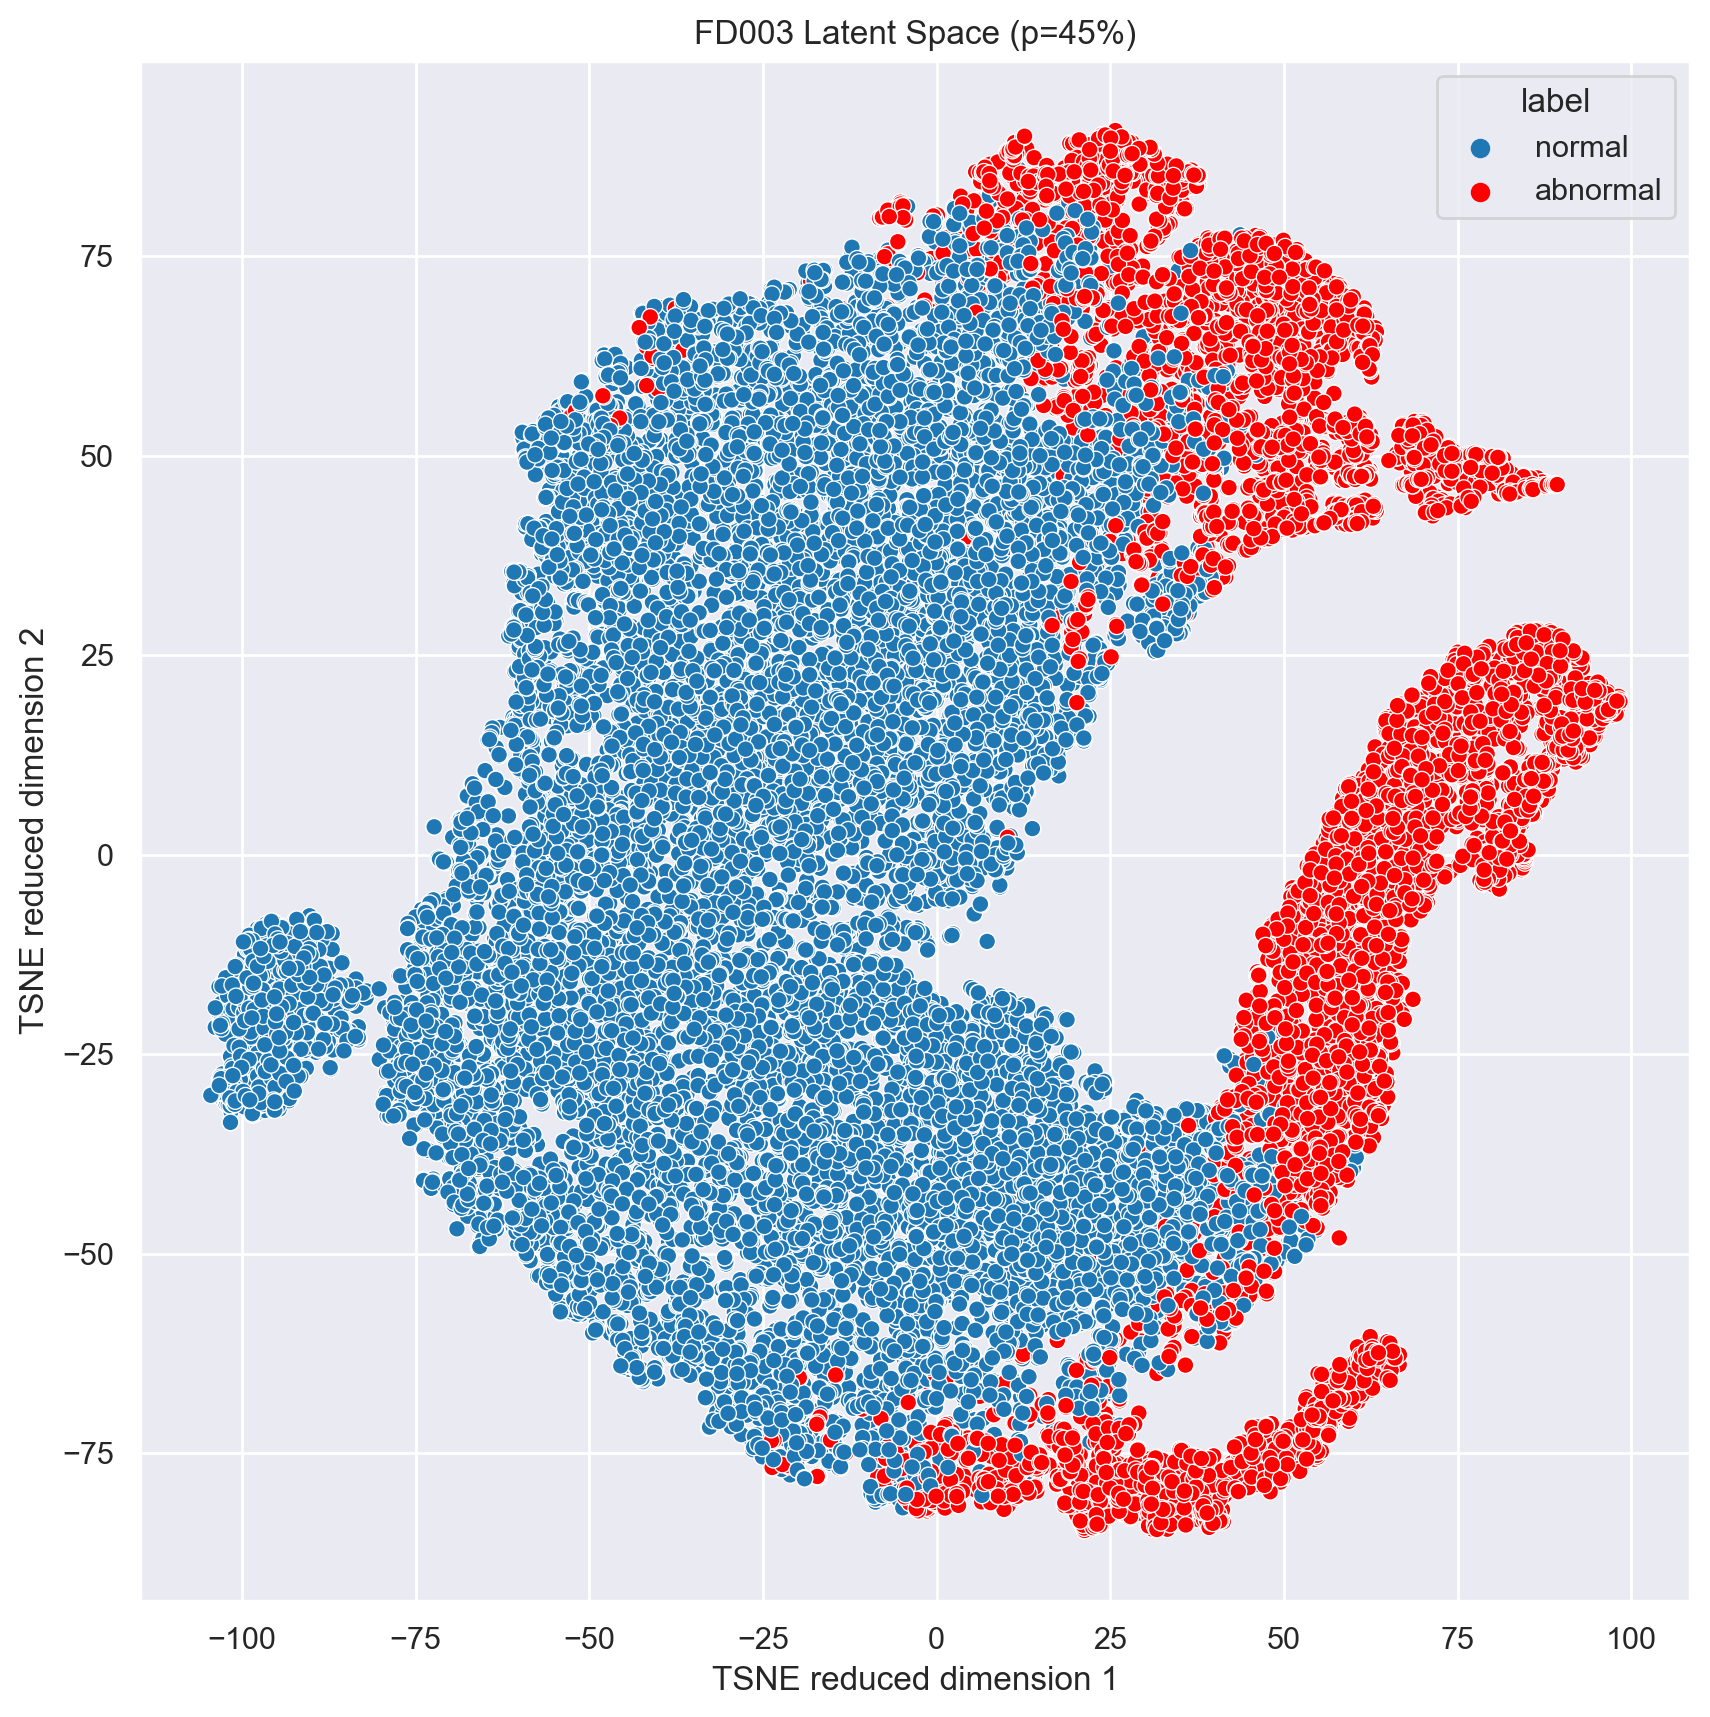

In [19]:
plot_latent_space(df_latent_space, title=f"{dataset} Latent Space (p={normal_op_len}%)")

# Visualize one of the training samples

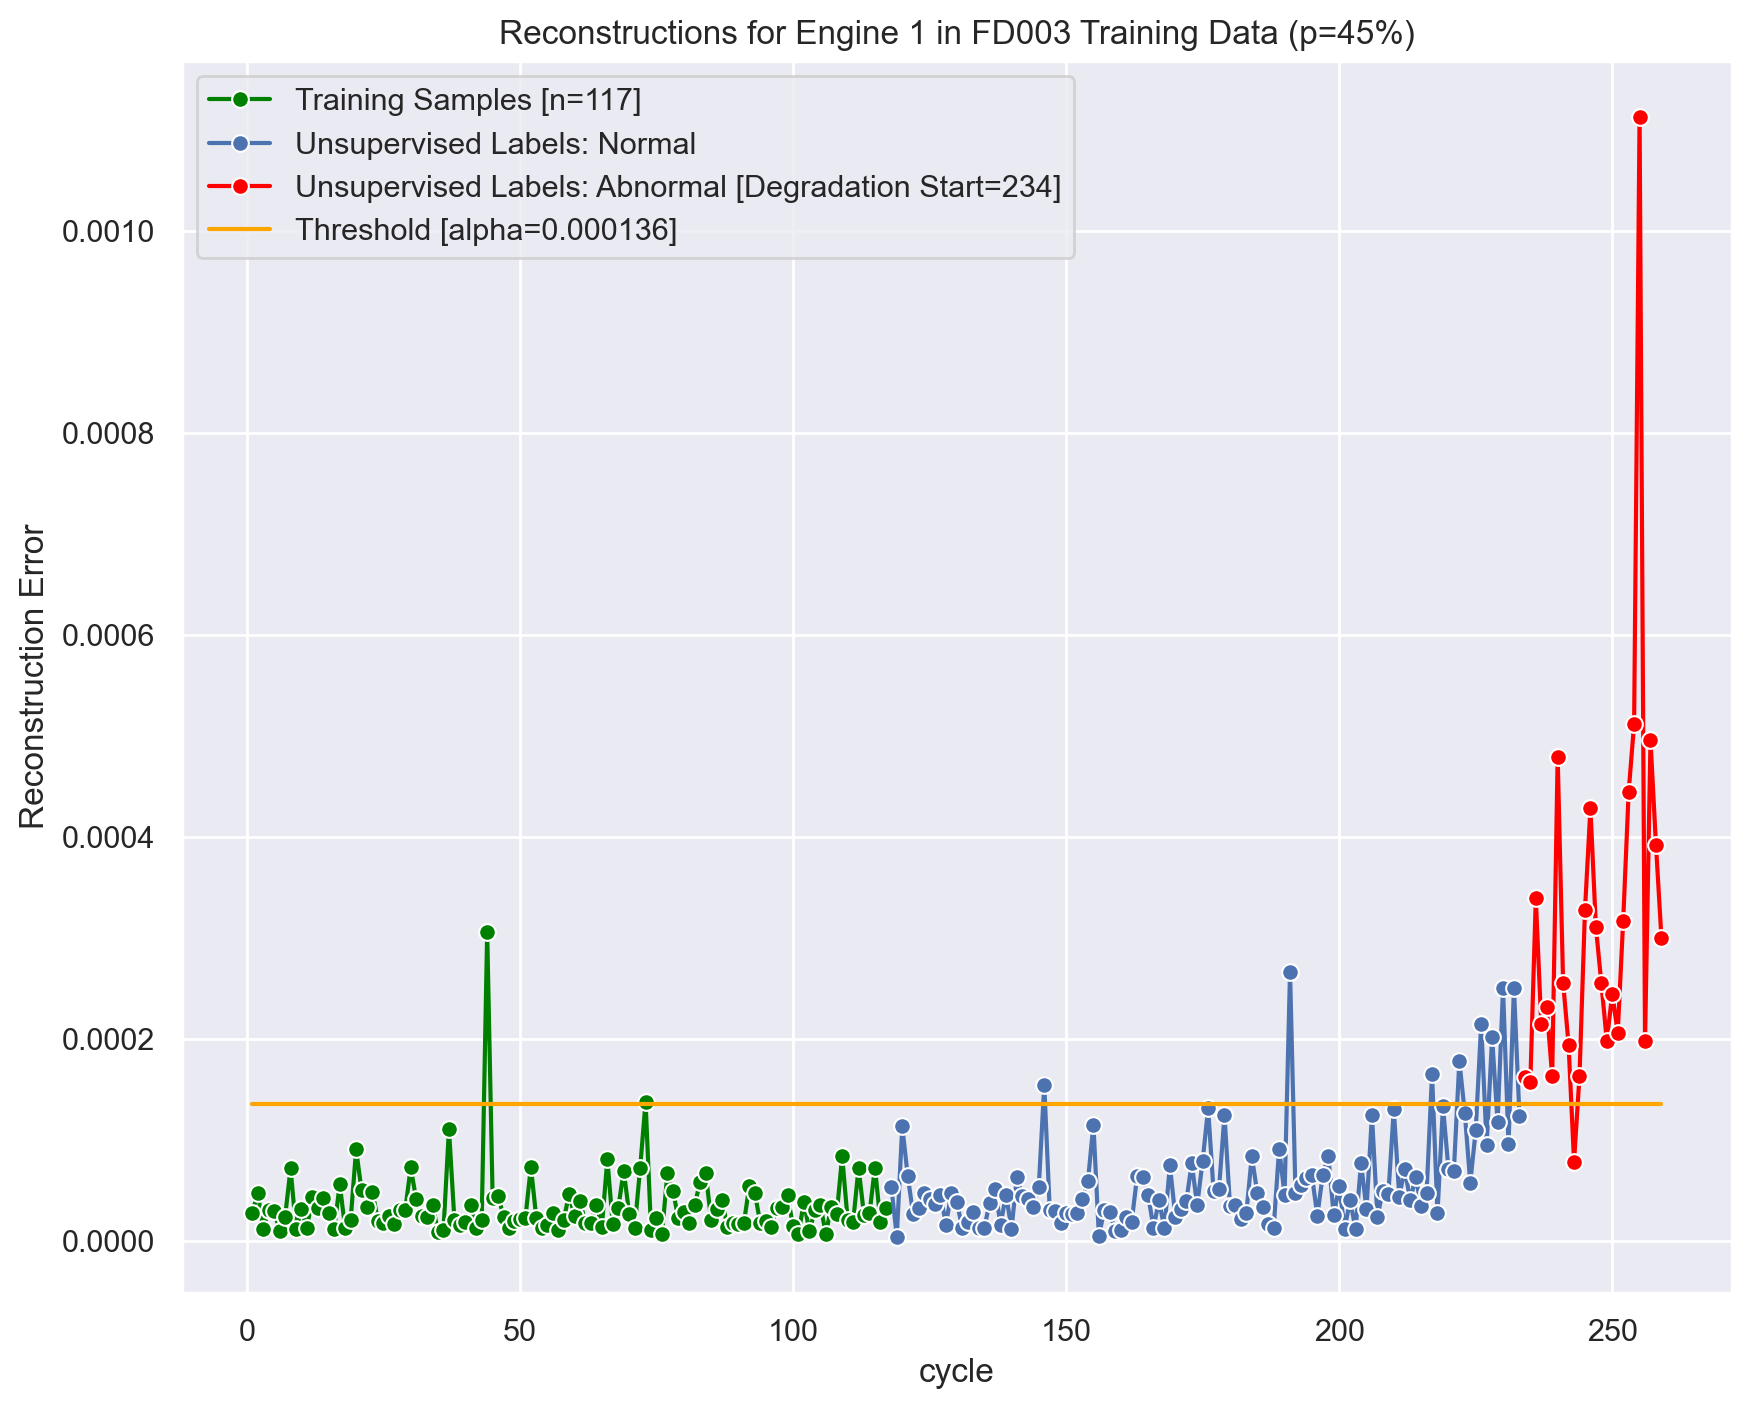

In [15]:
unit = 1
title = f"Reconstructions for Engine {unit} in {dataset} Training Data (p={normal_op_len}%)"
unit_threshold = unit_thresholds_dict[str(unit)]
df_unit = df_unsuperivsed_labels_training.query(f"unit=={unit}")
number_normal_samples = math.ceil((normal_op_len / 100) * len(df_unit)) if norm_op_len_as_pct else normal_op_len

plot_labels_recon_errors_and_threshold(model, 
                                       number_normal_samples=number_normal_samples, 
                                       df=df_unit, 
                                       threshold=unit_threshold,
                                       features=TURBOFAN_FEATURES_LIST, 
                                       title=title,
                                       recon_errors_title="Reconstruction Error",
                                       threshold_title=f"Threshold [alpha={unit_threshold:0.6f}]",
                                       x_axis_column="cycle", 
                                       show_zoom_ins=False)

# Visualize a testing sample

In [16]:
for unit in df_unsupervised_labels_testing.query("fault==1")["unit"].unique().tolist():
    print(unit)

3
5
14
16
18
21
22
23
24
25
26
30
33
39
40
46
48
49
50
64
71
76
78
79
81
82
86
89
90
92
94
96
98
99
100


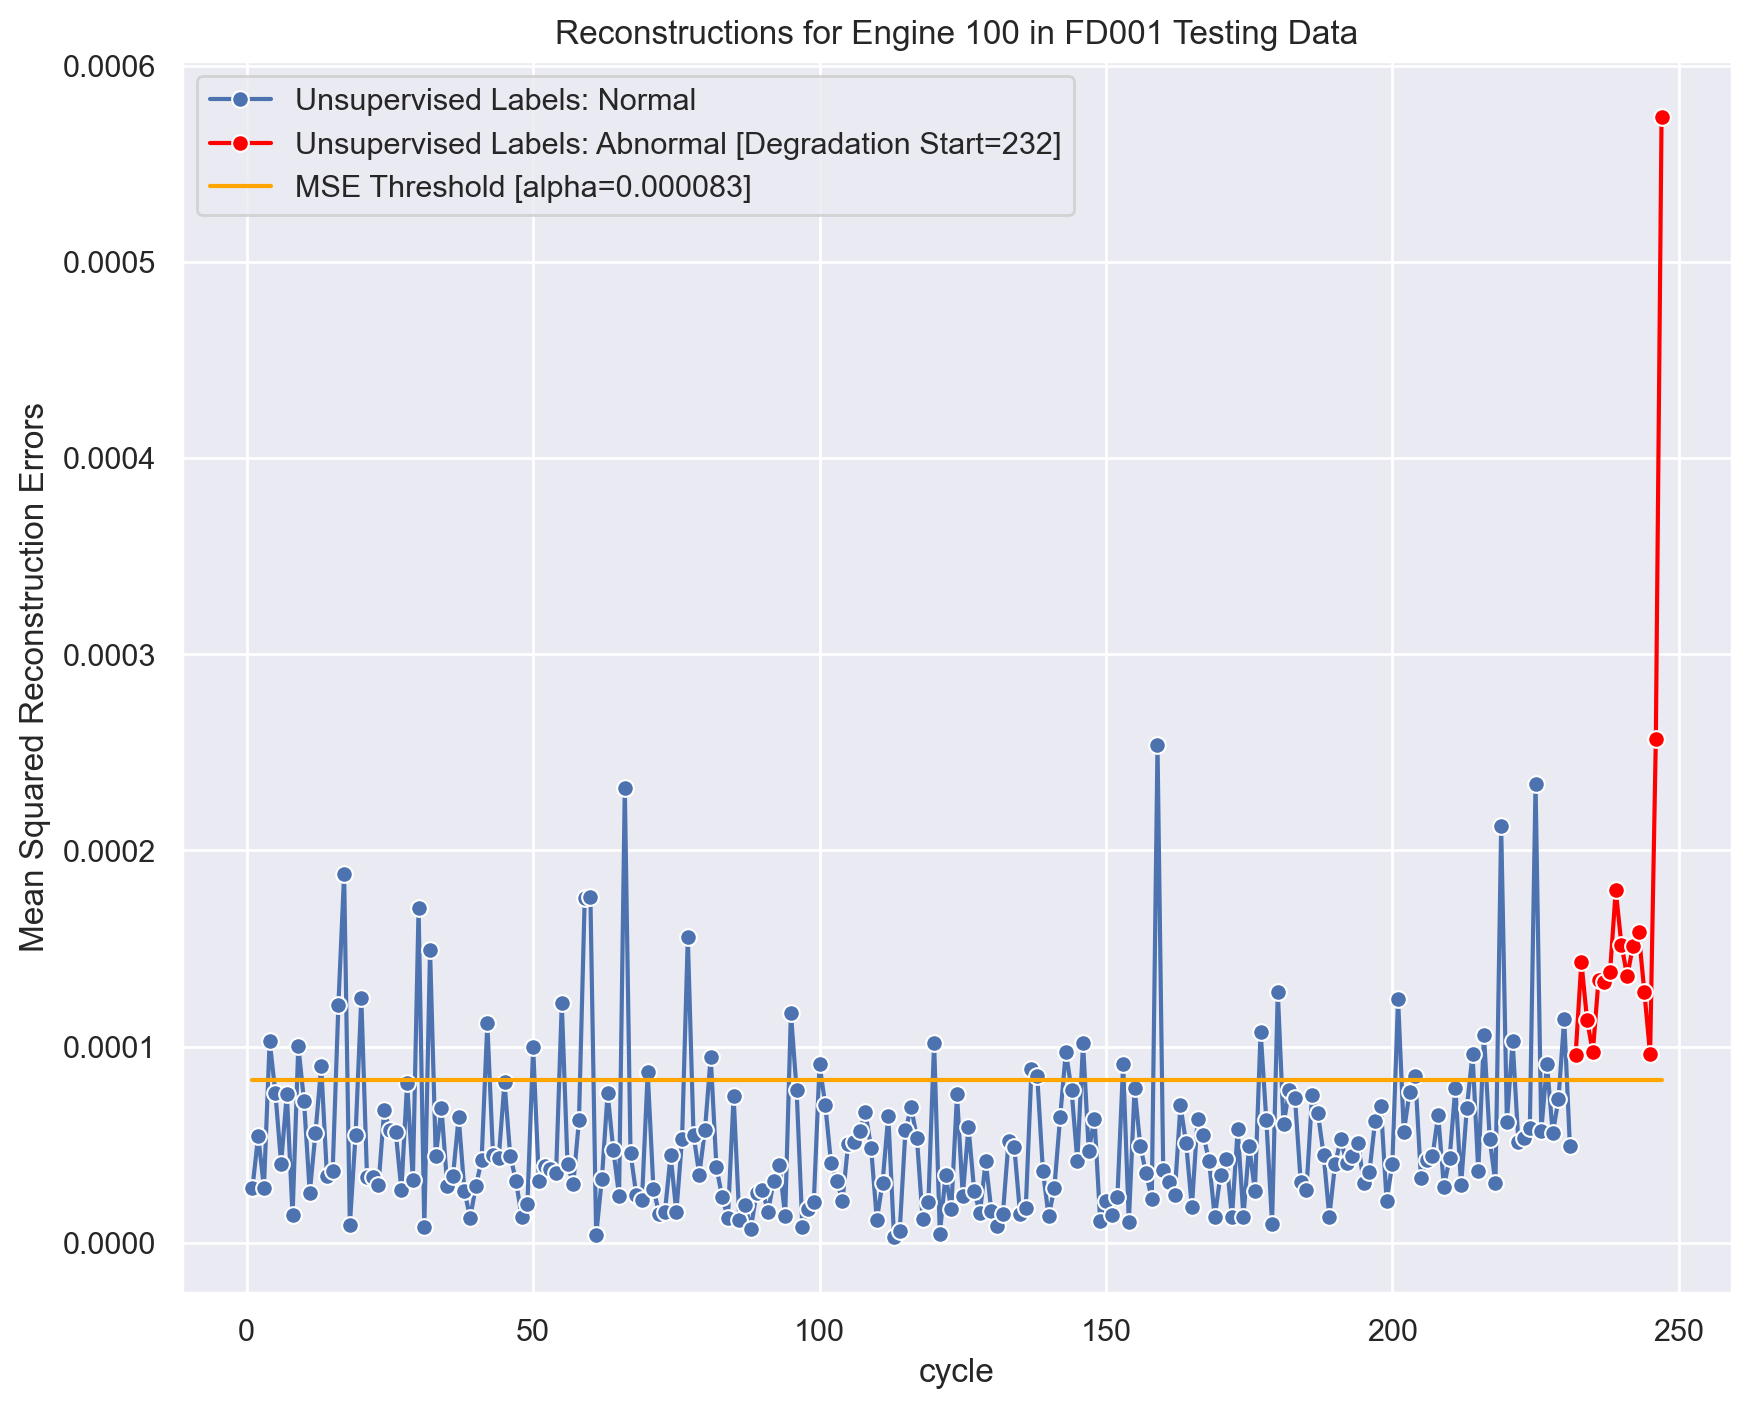

In [18]:
unit = 100
title = f"Reconstructions for Engine {unit} in FD001 Testing Data"
unit_threshold = unit_thresholds_dict[str(unit)]
df_unit = df_unsupervised_labels_testing.query(f"unit=={unit}")
number_normal_samples = math.ceil((normal_op_len / 100) * len(df_unit)) if norm_op_len_as_pct else normal_op_len

plot_labels_recon_errors_and_threshold(model, 
                                       number_normal_samples=0,
                                       df=df_unit, 
                                       threshold=unit_threshold,
                                       features=TURBOFAN_FEATURES_LIST,
                                       title=title,
                                       recon_errors_title="Mean Squared Reconstruction Errors", 
                                       threshold_title=f"MSE Threshold [alpha={unit_threshold:0.6f}]", 
                                       x_axis_column="cycle", 
                                       show_zoom_ins=False)

In [19]:
ruls = []
cycles = []
for unit in list(df_unsuperivsed_labels_training["unit"].unique()):
    df_unit = df_unsuperivsed_labels_training.query(f"unit=={unit} and fault==1")
    max_rul = df_unit["RUL"].max()
    cycle = df_unit["cycle"].min()
    
    ruls.append(max_rul)
    cycles.append(cycle)

print(f"Smallest Maximum RUL: {min(ruls)}")
print(f"Largets Maximum RUL: {max(ruls)}")
print(f"Average RUL: {np.mean(ruls)}")
print(f"Median RUL: {np.median(ruls)}\n")

print(f"Smallest Cycle: {min(cycles)}")
print(f"Largest Cycle: {max(cycles)}")
print(f"Average Cycle: {np.mean(cycles)}")
print(f"Median Cycle: {np.median(cycles)}")
# print(f"Largest_RUL + Median_RUL = {np.median(ruls) + max(ruls)}")

Smallest Maximum RUL: 17
Largets Maximum RUL: 180
Average RUL: 53.21
Median RUL: 46.0

Smallest Cycle: 82
Largest Cycle: 401
Average Cycle: 193.99
Median Cycle: 178.0


Smallest Cycle where a Fault Started: 82
Largest Cycle where a Fault Started: 401
Number of samples: 100


<Axes: ylabel='Count'>

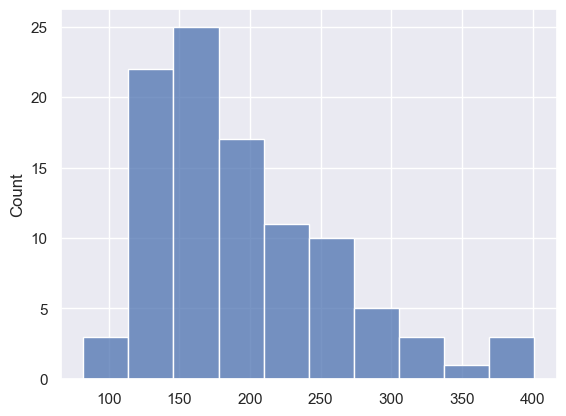

In [20]:
fault_start_training_data = []
for eng in df_unsuperivsed_labels_training["unit"].unique().tolist():
    df_unit = df_unsuperivsed_labels_training.query(f"unit=={eng} and fault==1")
    if len(df_unit) > 0:
        unit_fault_start = df_unit["cycle"].to_numpy()[0]
        fault_start_training_data.append(unit_fault_start)
    
print(f"Smallest Cycle where a Fault Started: {min(fault_start_training_data)}")
print(f"Largest Cycle where a Fault Started: {max(fault_start_training_data)}")
print(f"Number of samples: {len(fault_start_training_data)}")
sns.histplot(fault_start_training_data)

Smallest Cycle where a Fault Started: 5
Largest Cycle where a Fault Started: 397
Number of samples: 35


<Axes: ylabel='Count'>

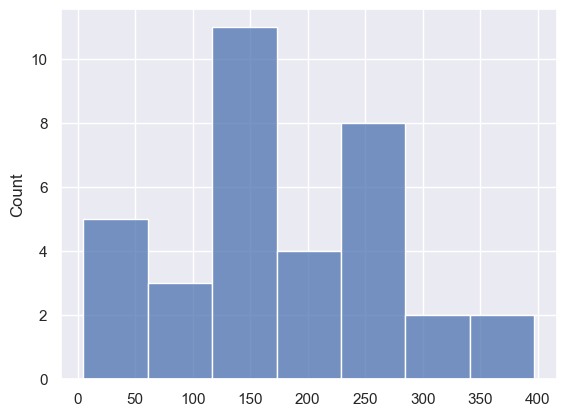

In [21]:
fault_start_testing_data = []
for eng in df_unsupervised_labels_testing["unit"].unique().tolist():
    df_unit = df_unsupervised_labels_testing.query(f"unit=={eng} and fault==1")
    if len(df_unit) > 0:
        unit_fault_start = df_unit["cycle"].to_numpy()[0]
        fault_start_testing_data.append(unit_fault_start)
        
        if unit_fault_start == 1:
            print(f"Unit={eng}")

print(f"Smallest Cycle where a Fault Started: {min(fault_start_testing_data)}")
print(f"Largest Cycle where a Fault Started: {max(fault_start_testing_data)}")
print(f"Number of samples: {len(fault_start_testing_data)}")
sns.histplot(fault_start_testing_data)